<a href="https://colab.research.google.com/github/SMN-SENAMHI/MONITOREO/blob/main/ERA5_SURFACE_MONTH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install -q xarray zarr "fsspec<=2025.3.0" "requests==2.32.4"


In [4]:
# ==============================================
# Guardar token en Colab (.netrc)
# ==============================================

#Reemplaza con tu token segun usuario registrado
TOKEN = "edh_pat_cfdba8b50c493e84dfc676f5f1efed1794dde11c40cd21237e54c21da72c2f9378c792defeb8e2ca4638ac478df26ab8"

# Crear el archivo .netrc en /root
with open("/root/.netrc", "w") as f:
    f.write("machine data.earthdatahub.destine.eu\n")
    f.write(f"  password {TOKEN}\n")

# Ajustar permisos (requerido por seguridad)
!chmod 600 /root/.netrc


In [5]:
import xarray as xr
import pandas as pd

# -----------------------------
# 1. Abrir dataset ERA5
# -----------------------------
url = "https://data.earthdatahub.destine.eu/era5/reanalysis-era5-single-levels-monthly-means-v0.zarr"

ds = xr.open_dataset(
    url,
    engine="zarr",
    chunks="auto",
    storage_options={"client_kwargs": {"trust_env": True}}
)

# -----------------------------
# 2. Variables con unidades y descripción
# -----------------------------
variables = []
for var in ds.data_vars:
    units = ds[var].attrs.get("units", "sin unidades")
    long_name = ds[var].attrs.get("long_name", "sin descripción")
    variables.append([var, units, long_name])

df = pd.DataFrame(variables, columns=["Variable", "Unidades", "Descripción"])
print("Variables disponibles en ERA5:\n")
print(df.to_string(index=False))

# -----------------------------
# 3. Rango temporal del dataset
# -----------------------------
fechas = pd.to_datetime(ds.valid_time.values)
inicio = fechas.min().strftime("%Y-%m")
fin    = fechas.max().strftime("%Y-%m")

print("\n Rango temporal del dataset ERA5:")
print(f"Inicio: {inicio}")
print(f"Fin:    {fin}")
print(f"Total de meses: {len(fechas)}")



Variables disponibles en ERA5:

Variable Unidades                  Descripción
     d2m        K 2 metre dewpoint temperature
     msl       Pa      Mean sea level pressure
      sp       Pa             Surface pressure
     sst        K      Sea surface temperature
     t2m        K          2 metre temperature
      tp        m          Total precipitation
     u10  m s**-1    10 metre U wind component
     v10  m s**-1    10 metre V wind component

 Rango temporal del dataset ERA5:
Inicio: 1940-01
Fin:    2025-07
Total de meses: 1027


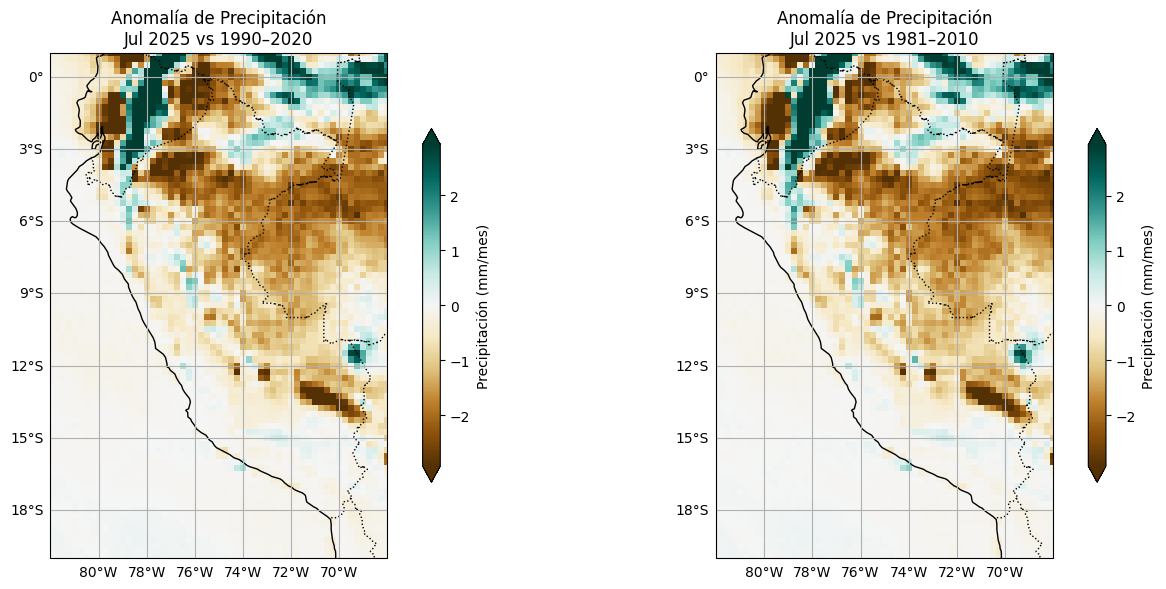

In [20]:
# ============================================
# 1. Instalar dependencias (solo en Colab)
# ============================================
#!apt-get install -y libproj-dev proj-data proj-bin libgeos-dev
!pip install -q cartopy xarray zarr fsspec requests

# ============================================
# 2. Importar librerías
# ============================================
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# ============================================
# 3. Abrir dataset ERA5 (requiere token en .netrc)
# ============================================
url = "https://data.earthdatahub.destine.eu/era5/reanalysis-era5-single-levels-monthly-means-v0.zarr"

ds = xr.open_dataset(
    url,
    engine="zarr",
    chunks="auto",
    storage_options={"client_kwargs": {"trust_env": True}}
)

# ============================================
# 4. Seleccionar variable (precipitación total) y convertir a mm/mes
# ============================================
tp = ds["tp"] * 1000  # ERA5 entrega en metros → convertir a mm
tp.attrs["units"] = "mm/mes"

# ================================================================
# Recortes aproximados por país (lat/lon en 0–360)
# ================================================================
# Recorte aproximado Sudamérica
#lat_min, lat_max = -60, 15
#lon_min, lon_max = 270, 330  # (-90 a -30 en 0–360)

# Perú
lat_min, lat_max = -20, 1
lon_min, lon_max = 278, 292   # (-82 a -68)

# Colombia
#lat_min, lat_max = -5, 13
#lon_min, lon_max = 281, 294   # (-79 a -66)

# Ecuador
#lat_min, lat_max = -5, 2
#lon_min, lon_max = 279, 285   # (-81 a -75)

# Chile
#lat_min, lat_max = -55, -17
#lon_min, lon_max = 285, 293   # (-75 a -67)

#Argentina
#lat_min, lat_max = -55, -21
#lon_min, lon_max = 287, 307   # (-73 a -53 en 0–360)

# Brasil
#lat_min, lat_max = -34, 5
#lon_min, lon_max = 286, 326   # (-74 a -34)

# Recorte del dataset
tp_sel = tp.sel(latitude=slice(lat_max, lat_min),
                longitude=slice(lon_min, lon_max))

# ============================================
# 5. Extraer Julio 2025
# ============================================
tp_202507 = tp_sel.sel(valid_time="2025-07")

# ============================================
# 6. Calcular climatologías
# ============================================
# 1990–2020
clim_1990_2020 = tp_sel.sel(valid_time=slice("1990-01", "2020-12"))
clim_1990_2020_jul = clim_1990_2020.sel(valid_time=clim_1990_2020["valid_time"].dt.month == 7)
clim_1990_2020_mean = clim_1990_2020_jul.mean("valid_time")

# 1981–2010
clim_1981_2010 = tp_sel.sel(valid_time=slice("1981-01", "2010-12"))
clim_1981_2010_jul = clim_1981_2010.sel(valid_time=clim_1981_2010["valid_time"].dt.month == 7)
clim_1981_2010_mean = clim_1981_2010_jul.mean("valid_time")

# ============================================
# 7. Anomalías (mm/mes)
# ============================================
anom_1990_2020 = tp_202507 - clim_1990_2020_mean
anom_1981_2010 = tp_202507 - clim_1981_2010_mean

# ============================================
# 8. Graficar con Cartopy
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6),
                         subplot_kw={"projection": ccrs.PlateCarree()})

for ax in axes:
    # Usar el recorte definido arriba
    ax.set_extent([lon_min-360, lon_max-360, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.coastlines(resolution="50m")
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.4)
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False

# Anomalía 1990–2020
anom_1990_2020.plot(
    ax=axes[0], transform=ccrs.PlateCarree(),
    cmap="BrBG", robust=True,
    cbar_kwargs={"label": "Precipitación (mm/mes)", "shrink": 0.7}
)
axes[0].set_title("Anomalía de Precipitación\nJul 2025 vs 1990–2020")

# Anomalía 1981–2010
anom_1981_2010.plot(
    ax=axes[1], transform=ccrs.PlateCarree(),
    cmap="BrBG", robust=True,
    cbar_kwargs={"label": "Precipitación (mm/mes)", "shrink": 0.7}
)
axes[1].set_title("Anomalía de Precipitación\nJul 2025 vs 1981–2010")

plt.tight_layout()
plt.show()


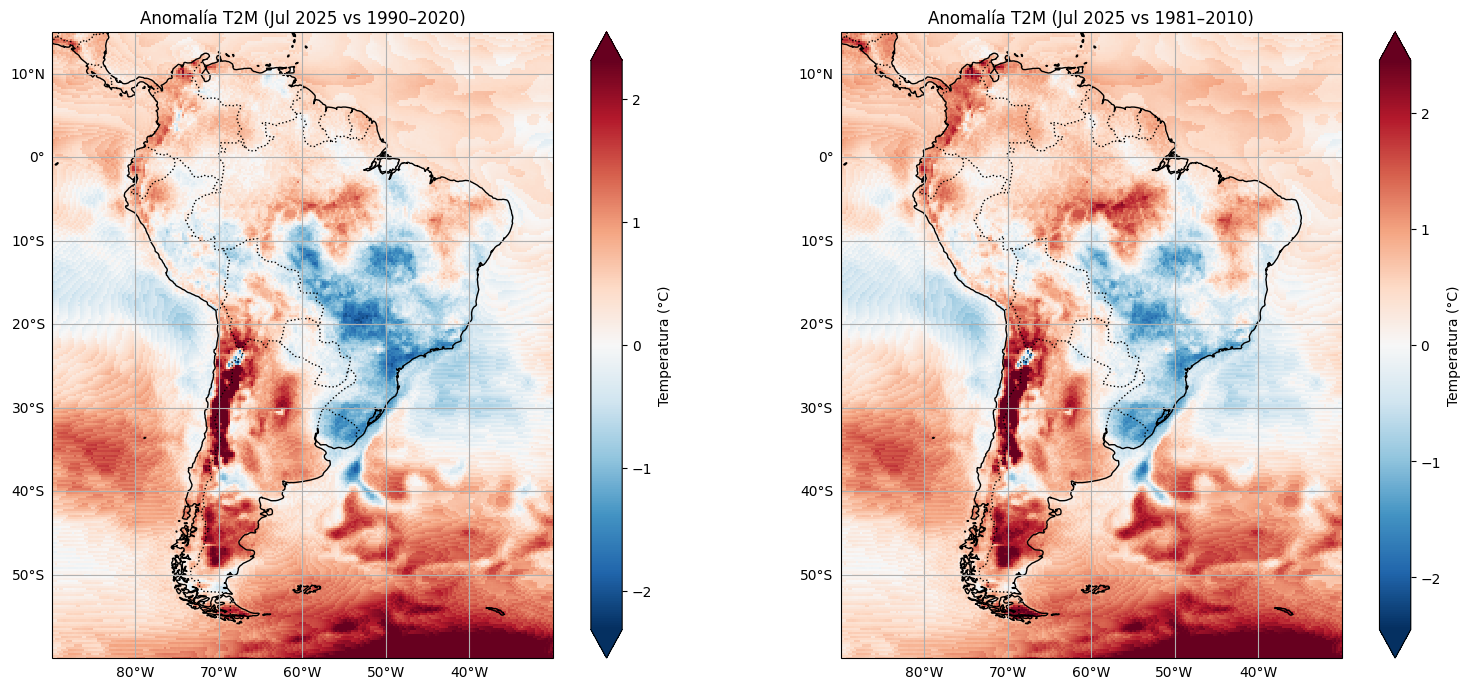

In [ ]:
# ============================================
# 1. Seleccionar temperatura a 2m (t2m) y convertir a °C
# ============================================
t2m = ds["t2m"] - 273.15
t2m.attrs["units"] = "°C"

# Recorte Sudamérica
t2m_sa = t2m.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))

# ============================================
# 2. Julio 2025
# ============================================
t2m_202507 = t2m_sa.sel(valid_time="2025-07")

# ============================================
# 3. Climatologías
# ============================================
# 1990–2020
clim_1990_2020 = t2m_sa.sel(valid_time=slice("1990-01", "2020-12"))
clim_1990_2020_jul = clim_1990_2020.sel(valid_time=clim_1990_2020["valid_time"].dt.month == 7)
clim_1990_2020_mean = clim_1990_2020_jul.mean("valid_time")

# 1981–2010
clim_1981_2010 = t2m_sa.sel(valid_time=slice("1981-01", "2010-12"))
clim_1981_2010_jul = clim_1981_2010.sel(valid_time=clim_1981_2010["valid_time"].dt.month == 7)
clim_1981_2010_mean = clim_1981_2010_jul.mean("valid_time")

# ============================================
# 4. Anomalías (°C)
# ============================================
anom_t2m_1990_2020 = t2m_202507 - clim_1990_2020_mean
anom_t2m_1981_2010 = t2m_202507 - clim_1981_2010_mean

# ============================================
# 5. Graficar con Cartopy
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(16, 7),
                         subplot_kw={"projection": ccrs.PlateCarree()})

for ax in axes:
    ax.set_extent([-90, -30, -60, 15], crs=ccrs.PlateCarree())
    ax.coastlines(resolution="50m")
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.4)
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False

# Anomalía 1990–2020
anom_t2m_1990_2020.plot(
    ax=axes[0], transform=ccrs.PlateCarree(),
    cmap="RdBu_r", center=0, robust=True,
    cbar_kwargs={"label": "Temperatura (°C)"}
)
axes[0].set_title("Anomalía T2M (Jul 2025 vs 1990–2020)")

# Anomalía 1981–2010
anom_t2m_1981_2010.plot(
    ax=axes[1], transform=ccrs.PlateCarree(),
    cmap="RdBu_r", center=0, robust=True,
    cbar_kwargs={"label": "Temperatura (°C)"}
)
axes[1].set_title("Anomalía T2M (Jul 2025 vs 1981–2010)")

plt.tight_layout()
plt.show()
